# IWME 502 / CIVL 598G - Advanced Engineering Hydrology

## Tutorial 1: Flow Measurement using the Salt Dilution Method

In [1]:
# import required packages
import pandas as pd
import numpy as np
import math

# plotting library
from matplotlib import pyplot as plt
# advanced statistics library
from scipy import stats

%matplotlib inline

### Given Information:

*(an example of a nicely formatted information table)*

| Parameter | Value | Units |
|---|---|---|
| Date of Measurement | 26 September 2010 | km<sup>2</sup> |
| Mass of Injected Salt | 100 | kg |

### Import the Salt Dilution Data

In [2]:
# instrument calibration data
sd_cal = pd.read_csv('data/SD_cal.csv')
# discharge measurement data
sd_data = pd.read_csv('data/SD_data.csv')

# data given in the calibration file
cal_solution_concn = 10 # g/L - this is the NaCl concentration in the calibration solution
cal_vol = 500 # total calibration volume mL 
cal_vol_increment = 1 # [mL] increments for calibration solution

In [3]:
#  add the volume of solution to the calibration volume
sd_cal['Calibration volume (ml)'] = cal_vol + sd_cal['Calibration solution added (ml)']

# calculate the equivalent salt mass added from the calibration solution volume
# and the calibration solution concentration.
sd_cal['Salt added (mg)'] = sd_cal['Calibration solution added (ml)'] * cal_solution_concn
sd_cal['Concentration (mg/l)'] = sd_cal['Salt added (mg)'] / (sd_cal['Calibration volume (ml)'] / 1000)

# drop empty rows
sd_cal.dropna(how='any', inplace=True)

## Correct Conductivity for Temperature

The electrical conductivity of water is a function of temperature, so it is important that the water used for calibration is the same temperature as the water in the stream being measured.  Alternatively, a temperature correction can be applied.

Presented below are two different methods of temperature compensation.

The instrument used in both the calibration and the measurement already has temperature compensation within the instrument, so the values recorded are EC at 25 C. 

In [4]:
def eu_std_ect_adjust(temp, ec):
    """
    Takes in a temperature (Theta), and an EC value,
    returns a temperature adjusted ECT value
    based on EU standard 27888 conversion.
    """
    c1 = -0.198058
    c2 = -1.992186
    c3 = 231.17628
    c4 = 86.39123
    r = c1 + math.exp(c2 + c3 / (temp + c4))
    c5 = 0.962144
    c6 = 0.965078
    c7 = 1.116
    f25 = ((1 - c5) + c5 * (r**c6)) * c7
    return ec * f25

def linear2_ect_adjust(temp, ec):
    """
    Takes in a temperature (Theta), and an EC value,
    returns a temperature adjusted ECT value
    based on linear interpolation with 2% at 25 degrees.
    """
    f25 = 2.0
    return ec / (1 + (f25 /100) * (temp - 25))


In [5]:
# Apply temperature compensation to the measured conductivity

# Note, in this case, the data is already temperature compensated 
# so this is not needed, but in many cases it is not, so it is left 
# here for reference
conductivity = sd_cal
temp_compensated = []
for i, row in sd_cal.iterrows():
    conductivity = row['Conductivity (microSiemens/cm)']
    temperature = row['Temperature (C)']

    # for each value in the conductivity time series,
    # apply the function to correct for temperature,
    # and add to the temp compensated array
    temp_ec = eu_std_ect_adjust(temp=temperature, ec=conductivity)
    temp_compensated.append(temp_ec)

# now add the temp_compensated array as a new column
# as stated above, this is left commented out as
# it is not needed in this case.
# sd_cal['ECT (us/cm)'] = temp_compensated
    
sd_cal

,Calibration volume (ml),Calibration solution added (ml),Salt added (mg),Concentration (mg/l),Conductivity (microSiemens/cm),Temperature (C)
0,500.0,0.0,0.0,0.000000,303.0,10.8
1,501.0,1.0,10.0,19.960080,343.0,10.8
2,502.0,2.0,20.0,39.840637,380.0,10.8
3,503.0,3.0,30.0,59.642147,426.0,10.8
4,504.0,4.0,40.0,79.365079,464.0,10.8
5,505.0,5.0,50.0,99.009901,505.0,10.8
6,506.0,6.0,60.0,118.577075,546.0,10.8


### Plot the calibration and best fit line

The calibration points are plotted with as red circles, which is represented by the two-character combination `ro`.  The best fit line through the calibration points is represented by a dashed blue line, specified by the three character code `b--`.  Changing the appearance of the plotted series is a matter of [looking up the short form](https://matplotlib.org/3.1.0/api/markers_api.html#module-matplotlib.markers).  

The `stats.linregress` function takes in two arrays and returns the equation of the best fit line through the data, along with information about the fit.  Note that the r-value is the correlation coefficient.  The coefficient of determination ($R^2$) is the r-value squared.

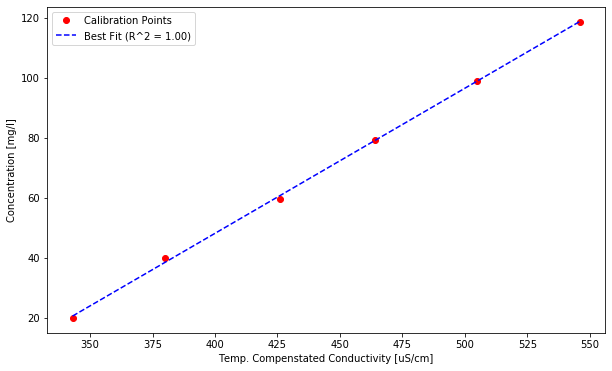

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

# ignore the first row (0, 0)
cond_series = sd_cal['Conductivity (microSiemens/cm)'].loc[1:]
conc_series = sd_cal['Concentration (mg/l)'].loc[1:]

# add the calibration points to the plot
plt.plot(cond_series, conc_series, 'ro', label="Calibration Points")

# plt.set_ylabel('Temp. Compenstated Conductivity [uS/cm]')
ax.set_xlabel('Temp. Compenstated Conductivity [uS/cm]')
ax.set_ylabel('Concentration [mg/l]')

# add best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(cond_series,
                                                                    conc_series)
#  create an array between the minimum and maximum calibration points
x_range = np.linspace(cond_series.min(), cond_series.max(),  100)

# use the best fit slope and intercept to construct the best fit line
best_fit = [x * slope + intercept for x in x_range]

# add the best fit line to the plot
plt.plot(x_range, best_fit, 'b--', label='Best Fit (R^2 = {:.2f})'.format(r_value**2))

# by default a legend is not shown, so we need to call the attribute.
plt.legend()

In [15]:
from bokeh.plotting import figure, output_notebook, show

# output to notebook
output_notebook()

p = figure(plot_width=400, plot_height=400)

# add a circle renderer with a size, color, and alpha
p.circle(cond_series, conc_series, size=10, color="navy", alpha=0.5)

# show the results
show(p)

Loading BokehJS ...

### Best Fit slope and R<sup>2</sup> of calibration points

Below, the print statement is comprised of a string.  In ths string, the `{}` symbols appear twice where I want to insert input from two different variables.  In this case, the values inside the curly brackets `{:.2f}` means I want a **float** of **2** decimal places.  There are a number of ways to insert variable values in strings for output.  More information on string formatting can be [found here](https://www.python.org/dev/peps/pep-3101/).

The `\n` in the string breaks the line in the printed output.

In [7]:
#note: the number of decimals in the slope is too low. adjust the line below to print one more decimal.
print('The calibration best fit slope is {:.2f} [[mg/L] / [uS/cm]] \n and the coefficient of determination of the calibration is {:.2f}.'.format(slope, r_value**2))

The calibration best fit slope is 0.48 [[mg/L] / [uS/cm]] 
 and the coefficient of determination of the calibration is 1.00.


### Plot the measurement

Now we'll use the second source of data corresponding to when the conductivity sensor was placed downstream some distance from where the salt was deposited in the creek.  

We plot the conductivity over time, and we also determine what the 'background' conductivity was in order to calculate the area under the conductivity curve.

In [8]:
# start and end time of the measurement (seconds)
# normally you will plot the data first, and adjust these to where you 
# determine the start and end of the salt injection
msmt_start = 190
msmt_end = 550


In [9]:
# the background is the natural level of conductivity prior to the salt injection
start_bg = 0  # set the time (in seconds) for the start point of the background
end_bg = 150  # set the time (in seconds) for the end point of the background

# here, the mean of the background over a certain period is calculated as the representative background EC.T
background_ect = sd_data['ECT (uS/cm)'].iloc[start_bg: end_bg].mean()

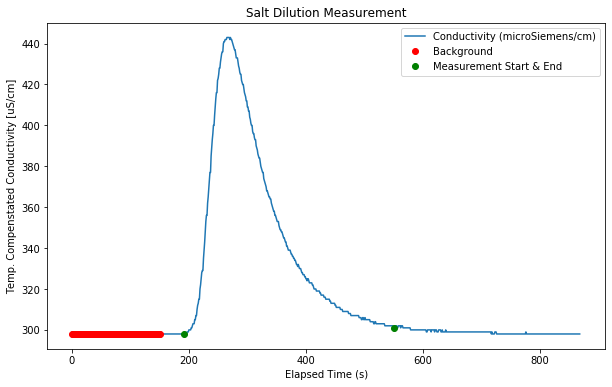

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

# plot the conductivity vs. time
ax.plot(sd_data['Time (s)'], sd_data['ECT (uS/cm)'], label="Conductivity (microSiemens/cm)")

# label the axes, and set the plot title
ax.set_xlabel('Elapsed Time (s)')
ax.set_ylabel('Temp. Compenstated Conductivity [uS/cm]')
ax.set_title('Salt Dilution Measurement')

ax.plot(sd_data['Time (s)'].iloc[start_bg: end_bg], 
              sd_data['ECT (uS/cm)'].iloc[start_bg: end_bg], 'ro',
                label='Background')

ax.plot(sd_data['Time (s)'].iloc[msmt_start], 
        sd_data['ECT (uS/cm)'].iloc[msmt_start], 'go',
        label='Measurement Start & End')

ax.plot(sd_data['Time (s)'].iloc[msmt_end], 
        sd_data['ECT (uS/cm)'].iloc[msmt_end],
       'go')

plt.legend()

## Why is the background important?

The two plots below look closer at the background before and after.  

The first series representing the conductivity before the measurement (i.e. from time = 0 to the first green point) is given.  

## **Your task** 

Plot a second series representing the background from the end of the measurement (second green point) until the end of the conductivity time series.  Consider how to present this information given that we are trying to highlight the comparison between the background measurements before and after.  Try changing the plot to make a stronger visual comparison.

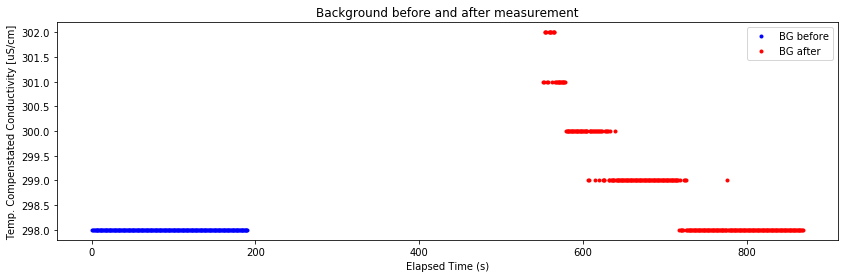

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))

# label the axes, and set the plot title
ax.set_xlabel('Elapsed Time (s)')
ax.set_ylabel('Temp. Compenstated Conductivity [uS/cm]')
ax.set_title('Background before and after measurement')

# look at the data before what was set as the beginning of the measurement (first green point)
# plot the conductivity before the measurement
ax.plot(sd_data['Time (s)'].iloc[: msmt_start],
        sd_data['ECT (uS/cm)'].iloc[: msmt_start], 
        'b.', label='BG before')

# now plot the conductivity from the end of the measurement (second green point)
# to the end of the whole series

ax.plot(sd_data['Time (s)'].iloc[msmt_end :],
        sd_data['ECT (uS/cm)'].iloc[msmt_end :], 
        'r.', label='BG after')
ax.legend()
plt.show()

### Calculate the Discharge
Calculate the area under the curve


The area is: $$A_{curve} = \sum_{i=start}^{end} (ECT_i - ECT_{BG,i}) \cdot Slope_{calibration} \cdot t_{step,i} = \frac{\mu S}{cm} \cdot \frac {mg/L}{\mu S/cm} \cdot s = \frac {mg}{L} \cdot s$$
Then discharge (Q) is calculated by: $\frac{m_{salt}}{A_{curve}} = \frac{M\cdot kg \cdot \frac{1x10^6 mg}{1kg}}{\frac {mg}{L} \cdot \frac{1000 L}{1m^3} \cdot s} = \frac {m^3}{s}$

To illustrate, we are calculating the total area under the curve:

![Area under conductivity curve](img/a1.png)

And we are subtracting the rectangle representing the background.

![Background Area](img/a2.png)


In [12]:
sd_data.head()

,Time (s),ECT (uS/cm),Temperature (C)
0,1,298,10.8
1,2,298,10.8
2,3,298,10.8
3,4,298,10.8
4,5,298,10.8


In the cell below, we are calculating the area under the conductivity curve (`ECT (uS/cm`) and subtracting our background average determined above. 

Change the calculation so it only takes into account the part of the wave between the start and stop markers, i.e. `msmt_start` and `msmt_stop`.  

*Hint, how was the background average (`background_ect`) calculated previously?* 

In [13]:
sd_data['t_elapsed'] = sd_data['Time (s)']

sd_data['Concentration'] = (sd_data['ECT (uS/cm)'] - background_ect) * slope

time_step = 1 # the time step of the EC measurement device is 1s

conc_Area = sum(sd_data['Concentration'] * time_step)

mass = 100 # 100 kg salt was dumped in the river

Q_calculated = mass * 1000 / conc_Area

print('The calculated discharge for the measurement is {:.2f} m^3/s'.format(Q_calculated))

The calculated discharge for the measurement is 11.99 m^3/s


## How sensitive is the calculation?

We manually set the start and end of the salt injection using the `msmt_start` and `msmt_end` variables.  What if we don't set the end time properly?  Go back and change the `msmt_end` time and see the effect on the calculated discharge.